# Setting

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain langsmith langchain-community langchain-openai langchain_experimental langchainhub langgraph langchain_huggingface langchain-text-splitters "unstructured[md]" nltk tiktoken chromadb

In [2]:
# 환경변수 불러오기
import getpass
import os

def _set_env(var: str):
    ''' 환경변수에 없으면 입력 받을 수 있게하는 함수 '''
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [3]:
# LLM 지정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-3.5-turbo-0125", temperature=0) # gpt-4-turbo, gpt-4o-realtime-preview, gpt-4o-mini, gpt-4o

# Supervisor Node

- supervisor = LLM 노드 
- Agent Router를 통해 적절한 에이전트를 라우팅하고, 작업 완료 여부 결정함.

In [4]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from pydantic import BaseModel
from typing import Literal


# =========================[ 작업자 그룹 정의, 결정된 작업자 반환 양식 정의 ]==================================
members = ["Web_Researcher", "Job_DB_Researcher", "Major_DB_Researcher", "University_DB_Researcher"]
options = ["FINISH"] + members

class RouteResponse(BaseModel):
    next: Literal[*options]


# =========================[ 수퍼바이저 시스템 프롬프트 ]==================================
# 한국어 프롬프트를 사용하려면 members 이름도 한국어로 해야함. 그리고 추가 설명도 해줘야 잘됨.
# 영어로 할 때는 그냥 기본 프롬프트 쓰는게 더 잘됨. 추가 설명해주니까 오히려 틀림.
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


# =========================[ 수퍼바이저 정의 ]==================================
def supervisor_agent(state):
    """Supervisor가 대화의 흐름을 제어하고 다음 작업을 수행할 에이전트를 선택"""
    # 수퍼바이저(체인) : 시스템 프롬프트 + 반환 양식 
    # LLM을 통해 적합한 작압자 선정한 후 양식에 맞게 반환.
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)
    return supervisor_chain.invoke(state)

### [TEST] Supervisor

---

In [183]:
def test_supervisor(query):    
    # 테스트를 위한 상태(state)를 설정 (사용자 메시지 시뮬레이션)
    state = {
        "messages": [
            {"role": "user", "content": query},  # 사용자 질문
        ]
    }

    # 수퍼바이저 에이전트 호출
    response = supervisor_agent(state)
    
    # 결과 출력
    print(f"Supervisor 선택: {response.next}")

In [184]:
# 진로상담 질의 -> Counselor
# 이전 상담사 질문 가정 : 어떤 활동을 할 때 흥미를 느끼나요?
query = "저는 무언가를 만드는 것을 좋아합니다. 특히 컴퓨터로 프로그램을 만드는것이 재밌는 것 같아요"
test_supervisor(query)

Supervisor 선택: Researcher


In [185]:
# 진로정보검색 질의 -> Researcher
test_supervisor("AI 엔지니어가 되려면 무엇을 준비해야 할까요?")

Supervisor 선택: Researcher


---

# Agent State

- `state` 객체는 그래프의 각 노드에 전달되는 상태.
- state는 `messages`의 리스트가 됨.
- 그래프의 각 노드가 여기에 추가됨. 

In [5]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# Annotated는 Python 타입 힌팅에 사용되는 유틸리티, 첫 번째 인자 : 실제 타입, 두 번째 인자 : 타입이 어떻게 사용되거나 처리될지 정보
# Sequence[BaseMessage] -> BaseMessage 객체를 담고 있는 시퀀스 타입(리스트, 튜플)
# Annotated[]의 두 번째 인자 기본값은 replace
# operator.add : 파이썬 기본 덧셈 연산, 여기서는 새로운 메시지가 추가될 때 기존 메시지 리스트에 더해져서 관리됨.
# add_messages : LangGraph 상태 관리에 특화된 방식으로 메시지 추가(대화턴에 HumanMessage로 감싸진 대화가 추가됨)
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    next: str # 다음 라우팅할 곳

### [TEST] Langgraph add_messsages VS Python operator.add

---

In [187]:
from operator import add
from typing import List
from langgraph.graph.message import add_messages

# 기존 메시지 리스트
messages = ["Message 1", "Message 2"]

# operator.add로 메시지 추가
added_messages_operator = add(messages, ["New Message using operator.add"])


# add_messages 방식으로 메시지 추가
added_messages_custom = add_messages(messages, ["New Message using add_messages"])

# 두 결과를 출력하여 비교
print("operator.add 방식 결과:", added_messages_operator)
print("add_messages 방식 결과:", added_messages_custom)

operator.add 방식 결과: ['Message 1', 'Message 2', 'New Message using operator.add']
add_messages 방식 결과: [HumanMessage(content='Message 1', additional_kwargs={}, response_metadata={}, id='4a2f5404-8442-4cbc-a1b4-4ff48a135543'), HumanMessage(content='Message 2', additional_kwargs={}, response_metadata={}, id='e6c954bf-f835-4662-ad60-9373a62a25e7'), HumanMessage(content='New Message using add_messages', additional_kwargs={}, response_metadata={}, id='fb0a9057-290e-4822-b2af-d125dd334212')]


---

# Tools

## Create Retriever

In [6]:
from langchain_huggingface.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from tqdm import tqdm


# 임베딩 모델 설정
model_name = "BAAI/bge-m3"
hf_embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs = {'device': 'cpu'}, # default
    encode_kwargs = {'normalize_embeddings': False}, # default
)

persist_dir = "./chroma_db" # 벡터 DB 저장경로

# docs_list와 컬렉션 이름 매핑
collections = {
    "careernet_job_db": {
        "search_type":"mmr",
        "search_kwargs":{
            "k": 5,
        }, 
    },
    "careernet_major_db": {
        "search_type":"mmr",
        "search_kwargs":{
            "k": 4,
        }, 
    },
    "careernet_univ_db": {
        "search_type":"similarity",
        "search_kwargs":{
            "k": 3,
        }, 
    }
}

retrievers = []
for item in collections:
    # 직업백과 벡터 데이터베이스 불러오기
    vectorstore = Chroma(
        embedding_function=hf_embeddings,  # 사용한 임베딩 모델과 동일한 함수
        persist_directory=persist_dir,     # 벡터 데이터베이스가 저장된 경로
        collection_name=item # 불러올 컬렉션 이름
    ) 
    retriever = vectorstore.as_retriever(
        search_type=collections[item]["search_type"],
        search_kwargs=collections[item]["search_kwargs"]     
    )
    retrievers.append(retriever)
    
    
print(retrievers)

/Users/ormor/root/DoWADO/Dowado-v2-Server/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/var/folders/n9/ts1r4j4j5r7c_b_rychx69lw0000gn/T/ipykernel_63429/2079095718.py:41: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(


[VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x1276eead0>, search_type='mmr', search_kwargs={'k': 5}), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x16e120590>, search_type='mmr', search_kwargs={'k': 4}), VectorStoreRetriever(tags=['Chroma', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x16e137e90>, search_kwargs={'k': 3})]


## Create Tools

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools.retriever import create_retriever_tool


# 웹 검색 도구
tavily_tool = TavilySearchResults(max_results=5)

# 벡터 DB 검색 도구
# retrievers = [직업백과, 전공정보, 대학정보]
job_retriever_tool = create_retriever_tool(
    retrievers[0],
    "retrieve_job_informations",
    "Search and return information about a specific job, including related job titles, academic majors, certifications, key responsibilities, aptitudes, career exploration activities, educational pathways, employment methods, job outlook, salary, job satisfaction, required skills, knowledge, and working environments.",
)

major_retriever_tool = create_retriever_tool(
    retrievers[1],
    "retrieve_major_informations",
    "Search and return information about a specific academic major, including employment rate, average starting salary, detailed description of the major, key characteristics, relevant aptitudes and interests, high school subjects, important college courses, career paths after graduation, career exploration activities, related certifications, associated job fields, detailed sub-majors, universities name offering the major, and interviews with professors.",
)

univ_retriever_tool = create_retriever_tool(
    retrievers[2],
    "retrieve_university_informations",
    "Search and return information about a specific university, including its name, university webpage URL, type of school (e.g., college, university), category (e.g., technical, polytechnic), founding type (e.g., public, private), location, and other relevant data.",
)


# tools = [job_retriever_tool, major_retriever_tool, univ_retriever_tool]

# Helper Utilities

In [8]:
from langchain_core.messages import HumanMessage


# 에이전트 호출하고, 그 결과 state를 HummanMessage 형식으로 변환
# 에이전트가 생성한 응답을 사용자에게 전달하기 위함
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

# Construct Graph

## Define Worker(작업자) Node

In [9]:
import functools
from langgraph.prebuilt import create_react_agent # 단순히 자동으로 에이전트 만들어줌(커스터마이징 X)


# 웹 검색 에이전트
web_research_agent = create_react_agent(llm, tools=[tavily_tool])
web_research_node = functools.partial(agent_node, agent=web_research_agent, name="Web_Researcher")

# 직업 벡터 DB 검색 에이전트
job_db_research_agent = create_react_agent(llm, tools=[job_retriever_tool])
job_db_research_node = functools.partial(agent_node, agent=job_db_research_agent, name="Job_DB_Researcher")

# 전공 벡터 DB 검색 에이전트
major_db_research_agent = create_react_agent(llm, tools=[major_retriever_tool])
major_db_research_node = functools.partial(agent_node, agent=major_db_research_agent, name="Major_DB_Researcher")

# 대학 벡터 DB 검색 에이전트
univ_db_research_agent = create_react_agent(llm, tools=[univ_retriever_tool])
univ_db_research_node = functools.partial(agent_node, agent=univ_db_research_agent, name="University_DB_Researcher")

## Define Workflow

In [10]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(AgentState)
workflow.add_node("Job_DB_Researcher", job_db_research_node)
workflow.add_node("Major_DB_Researcher", major_db_research_node)
workflow.add_node("University_DB_Researcher", univ_db_research_node)
workflow.add_node("Web_Researcher", web_research_node)
workflow.add_node("supervisor", supervisor_agent)

# Worker가 작업을 완료하면 항상 Supervisor에게 Report Back(보고) 하는 구조로 설계
for member in members:
    workflow.add_edge(member, "supervisor")
    
# Supervisor은 노드로 라우팅되거나 완료되는 그래프 State의 'next' 필드를 채움.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# entrypoint를 추가
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

# Display Graph

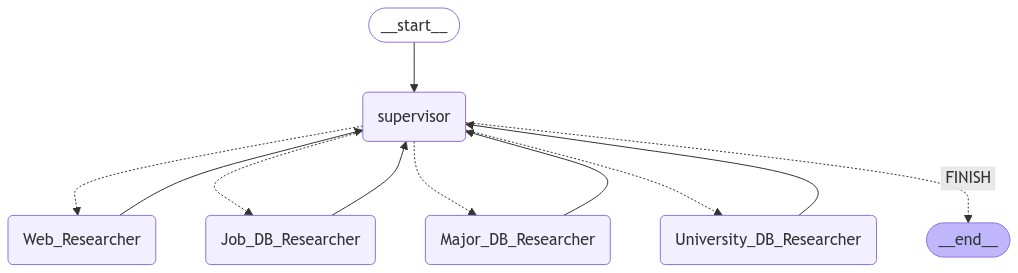

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # 여기에는 몇 가지 추가 종속성이 필요하며 선택 사항
    pass

# Invoke

In [34]:
for s in graph.stream({
    "messages": [
        HumanMessage(content="데이터 사이언티스트가 되고 싶은데 관련된 전공은 어떤게 있는지 각 대학별(한국)로 구분지어서 간단히 리스트업 해줘")
    ]
}):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Major_DB_Researcher'}}
----
{'Major_DB_Researcher': {'messages': [HumanMessage(content='데이터 사이언스와 관련된 전공들을 한국 대학들을 기준으로 간단히 리스트업해 드리겠습니다:\n\n1. 서울대학교\n   - 컴퓨터공학부 데이터사이언스전공\n   - 통계학과 데이터사이언스전공\n\n2. 고려대학교\n   - 컴퓨터학과 데이터사이언스전공\n   - 통계학과 데이터사이언스전공\n\n3. 연세대학교\n   - 컴퓨터과학전공 데이터사이언스트랙\n   - 통계학과 데이터사이언스트랙\n\n4. 한양대학교\n   - 컴퓨터공학부 데이터사이언스전공\n   - 통계학과 데이터사이언스전공\n\n5. 성균관대학교\n   - 컴퓨터공학과 데이터사이언스전공\n   - 통계학과 데이터사이언스전공\n\n6. 경희대학교\n   - 컴퓨터공학과 데이터사이언스전공\n   - 통계학과 데이터사이언스전공\n\n7. 서강대학교\n   - 컴퓨터공학과 데이터사이언스전공\n   - 통계학과 데이터사이언스전공\n\n8. 숙명여자대학교\n   - 컴퓨터과학전공 데이터사이언스트랙\n   - 통계학과 데이터사이언스트랙\n\n위 대학들에서 데이터 사이언스와 관련된 전공을 찾아보실 수 있습니다.', additional_kwargs={}, response_metadata={}, name='Major_DB_Researcher', id='e17ebfb7-edbf-4ad7-88db-20fd30f7861d')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


데이터 사이언스와 관련된 전공들을 한국 대학들을 기준으로 간단히 리스트업해 드리겠습니다:

1. 서울대학교
    - 컴퓨터공학부 데이터사이언스전공
    - 통계학과 데이터사이언스전공
    
2. 고려대학교
    - 컴퓨터학과 데이터사이언스전공
    - 통계학과 데이터사이언스전공

3. 연세대학교
    - 컴퓨터과학전공 데이터사이언스트랙
    - 통계학과 데이터사이언스트랙

4. 한양대학교
    - 컴퓨터공학부 데이터사이언스전공
    - 통계학과 데이터사이언스전공

5. 성균관대학교
    - 컴퓨터공학과 데이터사이언스전공
    - 통계학과 데이터사이언스전공

6. 경희대학교
    - 컴퓨터공학과 데이터사이언스전공
    - 통계학과 데이터사이언스전공

7. 서강대학교
   - 컴퓨터공학과 데이터사이언스전공
   - 통계학과 데이터사이언스전공

8. 숙명여자대학교
    - 컴퓨터과학전공 데이터사이언스트랙
    - 통계학과 데이터사이언스트랙

위 대학들에서 데이터 사이언스와 관련된 전공을 찾아보실 수 있습니다.

In [12]:
for s in graph.stream({
    "messages": [
        HumanMessage(content="저는 기계공학과에 진학하고 싶고, 졸업 후 3D 프린팅 전문가로 일하고 싶은데, 이 직업에 적합한 전공 과목과 관련된 자격증, 그리고 이 전공을 제공하는 대학 중 취업률이 높은 대학은 어디인가요?")
    ]
}):
    if "__end__" not in s:
        print(s)
        print("----")

{'supervisor': {'next': 'Major_DB_Researcher'}}
----
{'Major_DB_Researcher': {'messages': [HumanMessage(content='기계공학 전공에 대한 정보를 찾아보았습니다. \n\n### 졸업 후 3D 프린팅 전문가로 일하기 위한 정보:\n- **관련 전공 과목**: 기계설계, 열유체기계, 공조냉동기계, 생산용기계, 건축기계, 선박용기계, 발전관련 에너지 시스템 설계 및 제작기법 등\n- **관련 자격증**: 3D 프린팅 기술 관련 자격증을 취득하는 것이 도움이 될 수 있습니다.\n- **취업률이 높은 대학**: 국립공주대학교, 한국기술교육대학교, 국립군산대학교, 원광대학교, 전북대학교, 전주대학교, 전남대학교, 국립금오공과대학교, 국립안동대학교, 대구대학교, 영남대학교, 영산대학교 등이 있습니다.\n\n위 정보를 참고하여 기계공학 전공을 통해 3D 프린팅 전문가로 나아가는 데 도움이 될 것입니다. 추가로 교수님의 인터뷰도 참고하시면 좋을 것 같습니다.', additional_kwargs={}, response_metadata={}, name='Major_DB_Researcher', id='769eda2e-48f1-4cda-b231-42c10edf885b')]}}
----
{'supervisor': {'next': 'University_DB_Researcher'}}
----
{'University_DB_Researcher': {'messages': [HumanMessage(content='### 취업률이 높은 대학 정보:\n\n1. **국립공주대학교**\n   - **유형:** 국립대학교\n   - **위치:** 충청남도 공주시\n   - **관련 웹페이지:** [국립공주대학교 웹페이지](https://www.kongju.ac.kr/)\n\n2. **한국기술교육대학교**\n   - **유형:** 국립대학교\n   - **위치:** 충청남도\n   - **관련 웹페이지:** [한국기술교육대

기계공학 전공에 대한 정보를 찾아보았습니다. 

### 졸업 후 3D 프린팅 전문가로 일하기 위한 정보:
- **관련 전공 과목**: 기계설계, 열유체기계, 공조냉동기계, 생산용기계, 건축기계, 선박용기계, 발전관련 에너지 시스템 설계 및 제작기법 등
- **관련 자격증**: 3D 프린팅 기술 관련 자격증을 취득하는 것이 도움이 될 수 있습니다.
- **취업률이 높은 대학**: 국립공주대학교, 한국기술교육대학교, 국립군산대학교, 원광대학교, 전북대학교, 전주대학교, 전남대학교, 국립금오공과대학교, 국립안동대학교, 대구대학교, 영남대학교, 영산대학교 등이 있습니다.

위 정보를 참고하여 기계공학 전공을 통해 3D 프린팅 전문가로 나아가는 데 도움이 될 것입니다. 추가로 교수님의 인터뷰도 참고하시면 좋을 것 같습니다.

### 취업률이 높은 대학 정보:

1. **국립공주대학교**
    - **유형:** 국립대학교
    - **위치:** 충청남도 공주시
    - **관련 웹페이지:** [국립공주대학교 웹페이지](https://www.kongju.ac.kr/)

2. **한국기술교육대학교**
    - **유형:** 국립대학교
    - **위치:** 충청남도
    - **관련 웹페이지:** [한국기술교육대학교 웹페이지](http://www.koreatech.ac.kr/)
   
3. **국립군산대학교**
    - **유형:** 국립대학교
    - **위치:** 전라북도 군산시
    - **관련 웹페이지:** [국립군산대학교 웹페이지](http://www.kunsan.ac.kr/index.kunsan)

4. **원광대학교**
    - **유형:** 사립대학교
    - **위치:** 전북 익산시
    - **관련 웹페이지:** [원광대학교 웹페이지](http://www.wonkwang.ac.kr/)

5. **전북대학교**
    - **유형:** 국립대학교
    - **위치:** 전북 전주시 덕진구
    - **관련 웹페이지:** [전북대학교 웹페이지](http://www.jbnu.ac.kr/)

6. **전주대학교**
    - **유형:** 사립대학교
    - **위치:** 전북 전주시 완산구
    - **관련 웹페이지:** [전주대학교 웹페이지](http://www.jj.ac.kr/)

7. **전남대학교**
    - **유형:** 국립대학교
    - **위치:** 광주 북구
    - **관련 웹페이지:** [전남대학교 웹페이지](http://www.jnu.ac.kr/)

8. **국립금오공과대학교**
    - **유형:** 국립대학교
    - **위치:** 경남 진주시
    - **관련 웹페이지:** [국립금오공과대학교 웹페이지](http://www.kopo.ac.kr/jeonnam/index.do)

9. **국립안동대학교**
    - **유형:** 국립대학교
    - **위치:** 경북 안동시
    - **관련 웹페이지:** [국립안동대학교 웹페이지](http://www.andong.ac.kr/)

10. **대구대학교**
    - **유형:** 사립대학교
    - **위치:** 대구광역시 달서구
    - **관련 웹페이지:** [대구대학교 웹페이지](http://www.daegu.ac.kr/)

11. **영남대학교**
    - **유형:** 사립대학교
    - **위치:** 경북 경산시
    - **관련 웹페이지:** [영남대학교 웹페이지](http://www.yu.ac.kr/)

12. **영산대학교**
    - **유형:** 사립대학교
    - **위치:** 경북 경산시
    - **관련 웹페이지:** [영산대학교 웹페이지](http://www.ysu.ac.kr/)

위 대학들은 취업률이 높은 대학으로 알려져 있습니다. 추가적인 정보나 궁금한 점이 있으시면 언제든지 물어보세요!'